In [199]:
from google.colab import drive
drive.mount('/content/drive')

In [126]:
!ls "drive/My Drive/Facial_kaggle"

df_test.csv   face_images.npz  faces_total
df_train.csv  face_points.csv  facial_keypoints.csv


In [127]:
raw_csv_path = "drive/My Drive/Facial_kaggle/facial_keypoints.csv"
raw_imgs_path = "drive/My Drive/Facial_kaggle/face_images.npz"

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage import io
import random
import cv2
import shutil

In [5]:
raw_csv = pd.read_csv(raw_csv_path, memory_map=True)
raw_numR = len(raw_csv)
raw_numC = raw_csv.shape[1]
print(f"Number of rows: {raw_numR}, Number of columns: {raw_numC}")

Number of rows: 7049, Number of columns: 30


In [6]:
raw_csv['idx'] = range(0, raw_numR)
raw_colName = raw_csv.columns.tolist()
raw_colName = raw_colName[-1:] + raw_colName[:-1]
raw_csv = raw_csv[raw_colName]
raw_csv.head(3)

,idx,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368


### To check number of empty values in each columns and plot in bar graph.

In [7]:
raw_csv_emptyCols = raw_csv.isnull().sum(axis = 0)[1:]
raw_csv_emptyCols

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

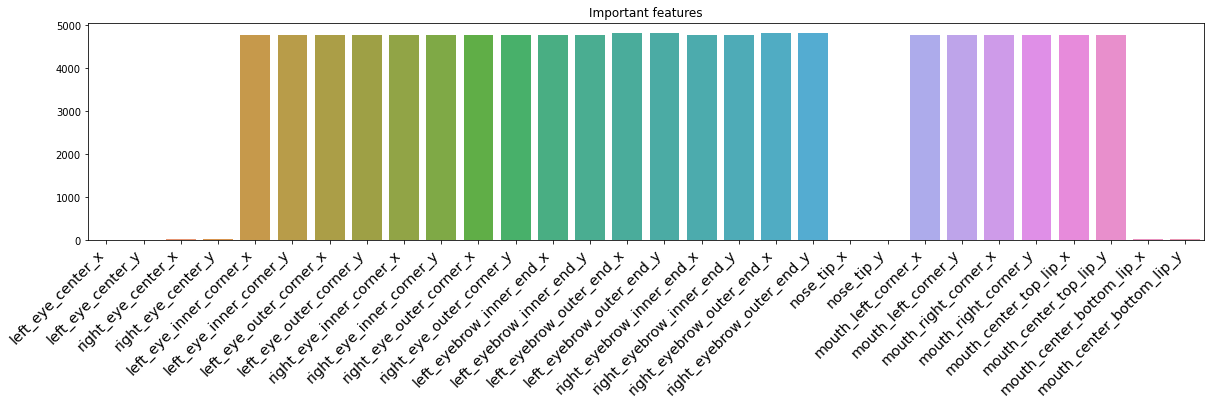

In [8]:
plt.rcParams['figure.figsize'] = [20, 4]
sns.barplot(x = raw_colName[1:], y = raw_csv_emptyCols).set_title('Important features')
plt.xticks(
    rotation = 45,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'x-large'
)
plt.show()

In [9]:
filt_cols = ['idx', 'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'nose_tip_x',
            'nose_tip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
filtered_csv = raw_csv[filt_cols]
filtered_csv = filtered_csv.dropna(axis = 0)
empty_filt_cols = filtered_csv.isnull().sum(axis = 0)
empty_filt_cols

idx                          0
left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

In [10]:
filtered_csv.to_csv('face_points.csv', index = False)

In [11]:
# from google.colab import files
# files.download('face_points.csv')

In [40]:
fp_path = "drive/My Drive/Facial_kaggle/face_points.csv"
face_points = pd.read_csv(fp_path)
face_points.tail(3)

,idx,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
6997,7046,66.690732,36.845221,31.666420,39.685042,49.462572,67.515161,49.462572,78.117120
6998,7047,70.965082,39.853666,30.543285,40.772339,50.754202,66.724988,50.065186,79.586447
6999,7048,66.938311,43.424510,31.096059,39.528604,47.069250,73.033339,45.900480,82.773096


In [41]:
raw_imgs = np.load(raw_imgs_path)['face_images']
print(f"Shape of images: {raw_imgs.shape}, dtype of images: {raw_imgs.dtype}, type: {type(raw_imgs)} ")

Shape of images: (96, 96, 7049), dtype of images: float64, type: <class 'numpy.ndarray'> 


In [42]:
img_ids = face_points['idx'].tolist()
raw_imgs = raw_imgs[:, :, img_ids]

In [43]:
def showImg(im, fp):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig = plt.figure()
    for i in range(10):
        im_x = []
        im_y = []
        fig.add_subplot(2,5,i+1)
        img = im[:, :, i+345]
        for j in range(1, 9, 2):
            im_x.append(fp.iloc[i+345, j])
            im_y.append(fp.iloc[i+345, j+1])
        plt.imshow(img, cmap='gray')
        plt.scatter(im_x, im_y, c = 'magenta')
        plt.axis(False)
    plt.show()

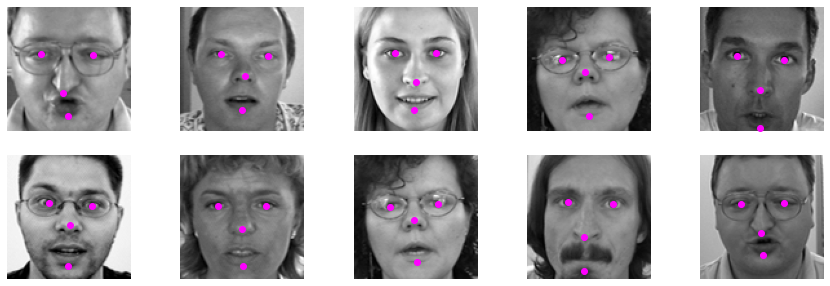

In [44]:
showImg(raw_imgs, face_points)

In [45]:
processed_img = []
for i in range(raw_imgs.shape[2]):
    img_bp = raw_imgs[:, :, i]
    img_ap = cv2.resize(img_bp, (224, 224), interpolation = cv2.INTER_NEAREST)
    processed_img.append(img_ap)
processed_img = np.array(processed_img, dtype = np.float32)
processed_img = processed_img.reshape(-1, 1, 224, 224)
print(f"Shape of images: {processed_img.shape}, dtype of images: {processed_img.dtype}, type: {type(processed_img)} ")

Shape of images: (7000, 1, 224, 224), dtype of images: float32, type: <class 'numpy.ndarray'> 


In [46]:
for col in face_points.columns:
    if col == 'idx':
        continue
    else:
        face_points[col] = face_points[col].astype('float32')

In [47]:
def face(image):
    image_name = []
    dir_name = 'drive/My Drive/Facial_kaggle/faces_total/'
    if os.path.exists(dir_name): shutil.rmtree(dir_name)
    os.mkdir(dir_name)
    global idx
    idx = 0
    for i in range(image.shape[0]):
        file_name = f"faces_{idx}.jpeg"
        im = image[i, 0, : , :]
        cv2.imwrite(os.path.join(dir_name, file_name), im)
        image_name.append(file_name)
        idx += 1
    return image_name
imgs_data = face(processed_img)
imgs_data = pd.DataFrame(imgs_data)

In [48]:
face_dataset = face_points
face_dataset['image_no'] = imgs_data[0]
face_dataset = pd.DataFrame(face_dataset.iloc[:, 1:])
face_dataset.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,image_no
0,66.033562,39.002274,30.227007,36.421677,44.420570,57.066803,43.130707,84.485771,faces_0.jpeg
1,64.332939,34.970078,29.949276,33.448715,48.206299,55.660934,45.467915,85.480171,faces_1.jpeg
2,65.057053,34.909641,30.903790,34.909641,47.557262,53.538948,47.274948,78.659370,faces_2.jpeg


In [49]:
cols = ['image_no','left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'nose_tip_x',
            'nose_tip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
face_dataset = face_dataset[cols]
face_dataset.head(3)

,image_no,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,faces_0.jpeg,66.033562,39.002274,30.227007,36.421677,44.420570,57.066803,43.130707,84.485771
1,faces_1.jpeg,64.332939,34.970078,29.949276,33.448715,48.206299,55.660934,45.467915,85.480171
2,faces_2.jpeg,65.057053,34.909641,30.903790,34.909641,47.557262,53.538948,47.274948,78.659370


In [50]:
for col in cols:
  if col == 'image_no':
    continue
  else:
    face_dataset[col] = face_dataset[col] * 224//96
face_dataset.head(3)

,image_no,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,faces_0.jpeg,154.0,91.0,70.0,84.0,103.0,133.0,100.0,197.0
1,faces_1.jpeg,150.0,81.0,69.0,78.0,112.0,129.0,106.0,199.0
2,faces_2.jpeg,151.0,81.0,72.0,81.0,110.0,124.0,110.0,183.0


In [51]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(face_dataset, test_size = 0.2, random_state = 0)
print(f"Length of training data: {len(df_train)}, length of testing data: {len(df_test)}")

Length of training data: 5600, length of testing data: 1400


In [52]:
df_train.to_csv('drive/My Drive/Facial_kaggle/df_train.csv', index = False)
df_test.to_csv('drive/My Drive/Facial_kaggle/df_test.csv', index = False)

In [129]:
df_train = pd.read_csv('drive/My Drive/Facial_kaggle/df_train.csv', )
df_test = pd.read_csv('drive/My Drive/Facial_kaggle/df_test.csv')

In [130]:
df_train.head(3)

,image_no,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,faces_6137.jpeg,157.0,97.0,70.0,93.0,118.0,147.0,115.0,184.0
1,faces_4778.jpeg,161.0,103.0,63.0,96.0,115.0,157.0,115.0,183.0
2,faces_3149.jpeg,150.0,84.0,68.0,85.0,103.0,165.0,104.0,184.0


In [131]:
def sampleImg(data):
  rand_choice = random.randint(0, 5600)
  print(f"Indexing image: {rand_choice}")
  root_dir = 'drive/My Drive/Facial_kaggle/faces_total/'
  img_path = os.path.join(root_dir, data.iloc[rand_choice, 0])
  img = io.imread(img_path)
  im_x =[]
  im_y = []
  for j in range(1,9,2):
    im_x.append(data.iloc[rand_choice, j])
    im_y.append(data.iloc[rand_choice, j+1])
  plt.imshow(img, cmap='gray')
  plt.scatter(im_x, im_y, c='magenta')
  plt.axis(False)
  plt.show()

Indexing image: 4722


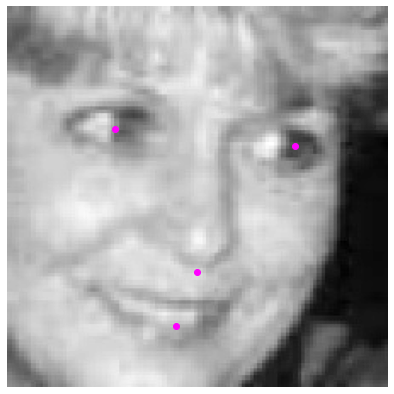

In [132]:
sampleImg(df_train)

In [133]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset

In [134]:
class fp_dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.csv_file = csv_file
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return len(self.csv_file)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_path = os.path.join(self.root_dir, self.csv_file.iloc[idx, 0])
    image = io.imread(img_path)
    fpts = np.array(self.csv_file.iloc[idx, 1:], dtype = np.float32).reshape(-1,2)
    if self.transform:
      sample_image = self.transform(image)
    else: sample_image = image
    return sample_image, torch.from_numpy(fpts)

In [135]:
class ToTensor(object):
  def __call__(self, sample_image):
    img = sample_image/255.
    img = np.array(img, dtype=np.float32)
    img = np.dstack((img, img, img))
    img = img.transpose((2,0,1))
    return torch.from_numpy(img)

In [136]:
tfms = transforms.Compose([
    ToTensor()
])

In [137]:
train_data = fp_dataset(csv_file=df_train, root_dir='drive/My Drive/Facial_kaggle/faces_total/', transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

In [138]:
print(f"Dataset length: {len(train_data)}, Dataloader_length: {len(train_loader)}")

Dataset length: 5600, Dataloader_length: 560


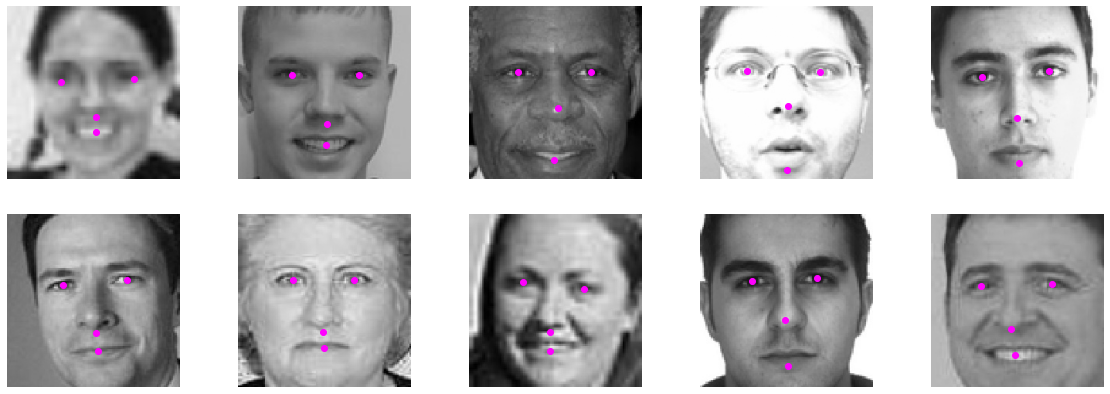

In [139]:
images, points = next(iter(train_loader))
def ten2num(imgS):
  img = imgS.clone().detach().numpy()
  img = img.transpose((1,2,0))
  return img
plt.rcParams['figure.figsize'] = [20,7]
fig = plt.figure()
for i in range(10):
  fig.add_subplot(2,5, i+1)
  plt.imshow(ten2num(images[i]))
  plt.scatter(points[i][:, 0], points[i][:, 1], c='magenta')
  plt.axis(False)
plt.show()

In [140]:
print(f"Poinst shape: {points.shape}, shape of each image: {images.shape}, Points datatype: {points.dtype}, Images datatype: {images.dtype}")

Poinst shape: torch.Size([10, 4, 2]), shape of each image: torch.Size([10, 3, 224, 224]), Points datatype: torch.float32, Images datatype: torch.float32


In [141]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [175]:
model = models.resnet101(pretrained=True).to(device)

In [176]:
model.fc = nn.Linear(2048, 8, bias = True)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [177]:
criterion = nn.SmoothL1Loss()
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt, milestones=[3, 6, 9])
epochs = 12
for e in range(epochs):
  tl = 0
  for images, points in train_loader:
    images = images.to(device)
    points = points.to(device)
    opt.zero_grad()
    train_out = model(images).view(-1 , 4 ,2)
    train_loss = criterion(train_out, points)
    tl += train_loss
    train_loss.backward()
    opt.step()
  print(f"epoch: {e}, loss: {tl/len(train_data)}")
  scheduler.step()

epoch: 0, loss: 2.1547155380249023
epoch: 1, loss: 0.42331355810165405
epoch: 2, loss: 0.32936161756515503
epoch: 3, loss: 0.2747472822666168
epoch: 4, loss: 0.2585984170436859
epoch: 5, loss: 0.2556028664112091
epoch: 6, loss: 0.24691621959209442
epoch: 7, loss: 0.24550418555736542
epoch: 8, loss: 0.2473355233669281
epoch: 9, loss: 0.24359309673309326
epoch: 10, loss: 0.24269096553325653
epoch: 11, loss: 0.2450283318758011


In [178]:
test_data = fp_dataset(csv_file=df_test, root_dir='drive/My Drive/Facial_kaggle/faces_total/', transform=tfms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

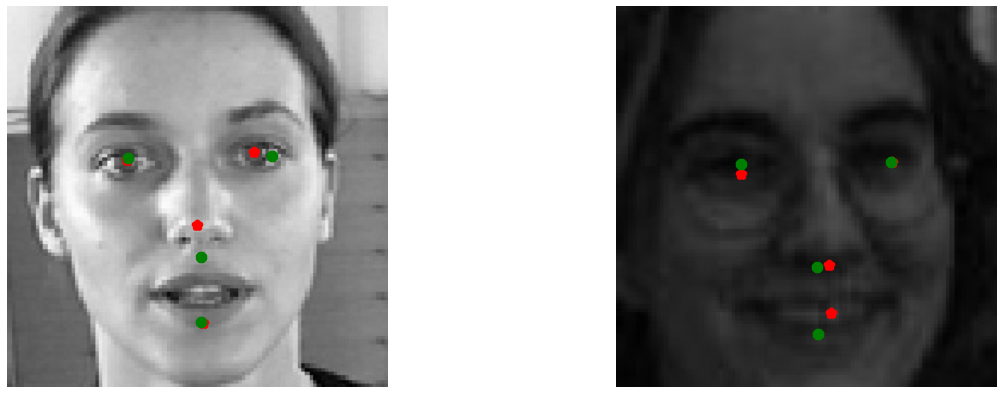

In [198]:
img_test, img_pts = next(iter(test_loader))
plt.rcParams['figure.figsize'] = [20,7]
fig = plt.figure()
for i in range(2):
  fig.add_subplot(1,2, i+1)
  test_image = img_test[i].unsqueeze(0)
  test_image = test_image.to(device)
  test_out = model(test_image).view(-1,2)
  test_out = test_out.clone().detach().cpu().numpy()
  plt.imshow(ten2num(img_test[i]))
  plt.scatter(img_pts[i][:, 0], img_pts[i][:, 1], c='red', linewidths=6, marker = '*')
  plt.scatter(test_out[:, 0], test_out[:, 1], c='green', linewidths=6, marker='8')
  plt.axis(False)
plt.show()